## Optimization Attempt # 3
    Remove "STATUS" column - presumed to not impact outcome.
    Create Bins for "ASK_AMT", given the wide range of Loan Ask Amounts, replace ASK_AMT column with ASK_BINS
    Increase threshold for "Other" bins for "APPLICATION_TYPE" and "CLASSIFICATION"
    Increase number of hidden layers to 8 
    Increase neurons per layer to 500 for the first layer and 300 for subsequent layers
    

## Preprocessing

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.callbacks import Callback, ModelCheckpoint

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore')

#  Import and read the charity_data.csv.
import pandas as pd
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

2023-08-29 10:44:58.828201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_clean = application_df.copy()
application_clean.drop(columns=["EIN","NAME","STATUS"], axis=1, inplace=True)
application_clean.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


In [3]:
# Determine the number of unique values in each column.
application_clean.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [4]:
#create variable for ask_amt
amt = application_clean["ASK_AMT"]

In [9]:
#create bins/labels for binning
bins = [0, 5001, 10000, 20000, 50000, 100000, 250000, 500000, 1000000, 10000000, 90000000000]
labels = [" 5K ", " 5K-10K ", " 10K-20k", " 20k-50k ", " 50k-100k ", "100k-250k", "250k-500k", "500k-1M", "1M-10M", ">10M" ]

In [10]:
#Bin ask_amts in new ask_bins column
application_clean["ASK_BINS"] = pd.cut(amt, bins, labels=labels)

In [12]:
#check bins
application_clean["ASK_BINS"].value_counts()

 5K           25399
 20k-50k       1609
100k-250k      1441
 50k-100k      1423
1M-10M         1165
250k-500k       863
 10K-20k        789
500k-1M         650
 5K-10K         548
>10M            412
Name: ASK_BINS, dtype: int64

In [13]:
#drop old ask_amt column
application_clean.drop(columns="ASK_AMT", axis=1, inplace=True)

In [17]:
# Look at APPLICATION_TYPE value counts for binning
application_values = application_clean["APPLICATION_TYPE"].value_counts()
application_values

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [18]:
#Compile values into dictionary
application_dict = application_values.to_dict()

In [19]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
application_types_to_replace = []

for key,value in application_dict.items():
  if value < 27037:
    application_types_to_replace.append(key)

# Replace in dataframe
for app in application_types_to_replace:
    application_clean['APPLICATION_TYPE'] = application_clean['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_clean['APPLICATION_TYPE'].value_counts()

T3       27037
Other     7262
Name: APPLICATION_TYPE, dtype: int64

In [20]:
# Look at CLASSIFICATION value counts for binning
class_values = application_clean["CLASSIFICATION"].value_counts()
class_values

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [21]:
# You may find it helpful to look at CLASSIFICATION value counts >1
class_values_limited = application_clean["CLASSIFICATION"].value_counts()[application_clean["CLASSIFICATION"].value_counts() >1]
class_values_limited

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: CLASSIFICATION, dtype: int64

In [22]:
# Convert value counts to dict
class_dict = class_values.to_dict()

In [23]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
classifications_to_replace = []

for key,value in class_dict.items():
  if value < 1883:
    classifications_to_replace.append(key)


# Replace in dataframe
for cls in classifications_to_replace:
    application_clean['CLASSIFICATION'] = application_clean['CLASSIFICATION'].replace(cls,"Other")

# Check to make sure binning was successful
application_clean['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [24]:
# application_clean.drop(columns=["CLASSIFICATION", "APPLICATION_TYPE", "INCOME_AMT"], axis=1, inplace=True)
application_clean.nunique()

APPLICATION_TYPE           2
AFFILIATION                6
CLASSIFICATION             6
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
IS_SUCCESSFUL              2
ASK_BINS                  10
dtype: int64

In [26]:
# Convert categorical data to numeric with `pd.get_dummies`
application_dummies = pd.get_dummies(application_clean, columns=["CLASSIFICATION", "APPLICATION_TYPE", \
                                                                 "ASK_BINS","USE_CASE","AFFILIATION", "ORGANIZATION","SPECIAL_CONSIDERATIONS","INCOME_AMT"])

application_dummies.head()

,IS_SUCCESSFUL,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,ASK_BINS_ 5K,...,SPECIAL_CONSIDERATIONS_Y,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,1,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# Split our preprocessed data into our features and target arrays
y = application_dummies["IS_SUCCESSFUL"].values.reshape(-1, 1)
X = application_dummies.copy()
X.drop(columns="IS_SUCCESSFUL", axis=1, inplace=True)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [28]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

In [29]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# Define the model - deep neural net
nn = tf.keras.models.Sequential()

#Define layers and neurons per layer
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  500
hidden_nodes_layer2 = 300
hidden_nodes_layer3 = 300
hidden_nodes_layer4 = 300
hidden_nodes_layer5 = 300
hidden_nodes_layer6 = 300
hidden_nodes_layer7 = 300
hidden_nodes_layer8 = 300


# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# # # Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# # Fifth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="relu"))

# # Sixth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer6, activation="relu"))

# # Seventh hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer7, activation="relu"))

# # Eighth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer8, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               22500     
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dense_3 (Dense)             (None, 300)               90300     
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                                 
 dense_5 (Dense)             (None, 300)               90300     
                                                                 
 dense_6 (Dense)             (None, 300)               9

2023-08-29 10:45:06.230309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)


Epoch 1/100
804/804 [==============================] - 6s 7ms/step - loss: 0.6004 - accuracy: 0.6954
Epoch 2/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5849 - accuracy: 0.7057
Epoch 3/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5831 - accuracy: 0.7080
Epoch 4/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5777 - accuracy: 0.7116
Epoch 5/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5791 - accuracy: 0.7090
Epoch 6/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5760 - accuracy: 0.7112
Epoch 7/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5755 - accuracy: 0.7108
Epoch 8/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5738 - accuracy: 0.7133
Epoch 9/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5732 - accuracy: 0.7136
Epoch 10/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5722 - accura

804/804 [==============================] - 5s 7ms/step - loss: 0.5473 - accuracy: 0.7279
Epoch 82/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5515 - accuracy: 0.7273
Epoch 83/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5486 - accuracy: 0.7284
Epoch 84/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5477 - accuracy: 0.7279
Epoch 85/100
804/804 [==============================] - 6s 7ms/step - loss: 0.5504 - accuracy: 0.7275
Epoch 86/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5489 - accuracy: 0.7279
Epoch 87/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5466 - accuracy: 0.7277
Epoch 88/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5497 - accuracy: 0.7275
Epoch 89/100
804/804 [==============================] - 5s 7ms/step - loss: 0.5587 - accuracy: 0.7260
Epoch 90/100
804/804 [==============================] - 6s 8ms/step - loss: 0.5573 - accuracy: 

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.8003 - accuracy: 0.7108 - 976ms/epoch - 4ms/step
Loss: 0.80030357837677, Accuracy: 0.7107871770858765


In [33]:
# Export our model to HDF5
nn.save('H5_Files/AlphabetSoupCharity_Optimization_3.h5')

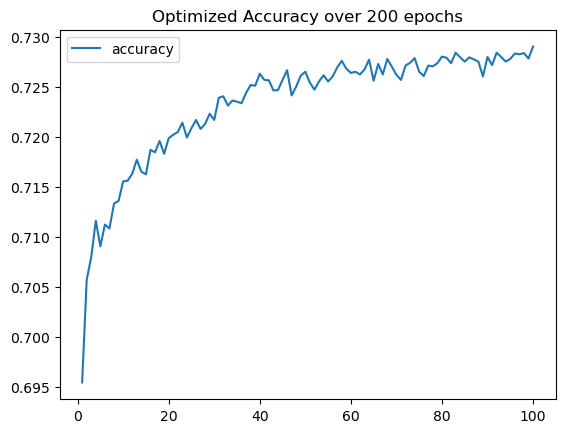

In [34]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="accuracy",title="Optimized Accuracy over 200 epochs")

plt.savefig('Plots/optimization_3_accuracy.png')
plt.show()

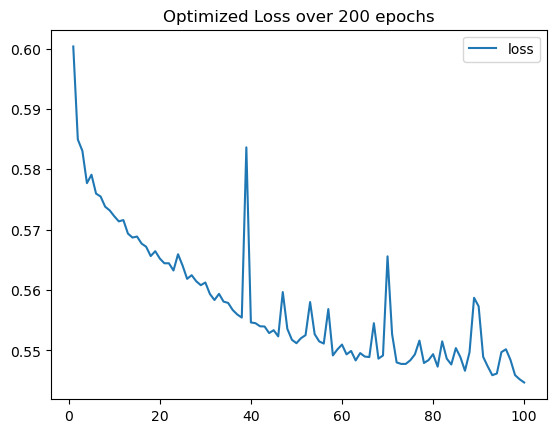

In [35]:
# Plot the loss
history_df.plot(y="loss", title="Optimized Loss over 200 epochs")

plt.savefig('Plots/optimization_3_loss.png')
plt.show()